In [ ]:
%%writefile segmentation_functions.py
# check if I can put again the main function - if it makes any sense

import numpy as np
import time
import scipy.ndimage.interpolation as inter
import cv2
import matplotlib.pyplot as plt
from skimage import morphology

def resize_mask(mask,img_size):
    resized_volume=[]
    for plot, each_slice in enumerate(mask):
        resized_image,resized_volume=resize_mask_slice(each_slice, img_size,resized_volume)
        
    volume = np.array(resized_volume)
    return volume

def resize_mask_slice(image, image_size, resized_volume):
    resized_image = cv2.resize(image,(image_size,image_size))
    resized_volume.append(resized_image)
    return resized_image, resized_volume

#__________________________________________________________________________________
def get_nbhd(pt, checked, dims):
"""code from Matt Hancock
http://notmatthancock.github.io/2017/10/09/region-growing-wrapping-c.html"""

    nbhd = []

    if (pt[0] > 0) and not checked[pt[0]-1, pt[1], pt[2]]:
        nbhd.append((pt[0]-1, pt[1], pt[2]))
    if (pt[1] > 0) and not checked[pt[0], pt[1]-1, pt[2]]:
        nbhd.append((pt[0], pt[1]-1, pt[2]))
    if (pt[2] > 0) and not checked[pt[0], pt[1], pt[2]-1]:
        nbhd.append((pt[0], pt[1], pt[2]-1))

    if (pt[0] < dims[0]-1) and not checked[pt[0]+1, pt[1], pt[2]]:
        nbhd.append((pt[0]+1, pt[1], pt[2]))
    if (pt[1] < dims[1]-1) and not checked[pt[0], pt[1]+1, pt[2]]:
        nbhd.append((pt[0], pt[1]+1, pt[2]))
    if (pt[2] < dims[2]-1) and not checked[pt[0], pt[1], pt[2]+1]:
        nbhd.append((pt[0], pt[1], pt[2]+1))

    return nbhd


def grow(img, seed, thresh_value, t,seg):
    """code adapted from Matt Hancock
    http://notmatthancock.github.io/2017/10/09/region-growing-wrapping-c.html
    
    img: ndarray, ndim=3
        An image volume.
    
    seed: tuple, len=3
        Region growing starts from this point.

    t: int
        The image neighborhood radius for the inclusion criteria.
        
    thresh: int
        The difference between the point considered and the segmentated 
        volume mean, below which we considered the point part of the segmented 
        volume. If the difference is above the thresh, it's not considered volume
    
    seg: used when we wish to do segmentation with two seeds
    """
    counter = 0

    half_volume = img.shape[1]//2
    #seg = np.zeros(img.shape, dtype=np.bool)
    checked = np.zeros_like(seg)
    max_seeding = 39705+50
    min_seeding = #para o 116
    seg[seed] = True
    checked[seed] = True
    needs_check = get_nbhd(seed, checked, img.shape)
    
    
    while len(needs_check) > 0 and counter < max_seeding:
        pt = needs_check.pop()

        # Its possible that the point was already checked and was
        # put in the needs_check stack multiple times.
        if checked[pt]: continue

        checked[pt] = True

        # Handle borders.
        imin = max(pt[0]-t, 0)
        imax = min(pt[0]+t, img.shape[0]-1)
        jmin = max(pt[1]-t, 0)
        jmax = min(pt[1]+t, img.shape[1]-1)
        kmin = max(pt[2]-t, 0)
        kmax = min(pt[2]+t, img.shape[2]-1)

        mean_checked = img[seg].mean()
        #difference = mean_checked - img[imin:imax+1, jmin:jmax+1, kmin:kmax+1].mean()
        #difference = img[pt] - img[imin:imax+1, jmin:jmax+1, kmin:kmax+1].mean()
        difference = img[pt] - mean_checked
        

        
        if abs(difference) <= thresh_value:
            # Include the voxel in the segmentation and
            # add its neighbors to be checked.
            
            seg[pt] = True
            counter = counter +1
            needs_check += get_nbhd(pt, checked, img.shape)
        if counter > max_seeding:
            plt.imshow(seg[:,half_volume,:])
            print("unvalid segmentation")
    plt.imshow(seg[:,half_volume,:])        
    return seg, counter
#__________________________________________________________________________________

def erode_volume(volume,number):
    eroded  = volume[:,:,0]
    for i in range(1,volume.shape[2]):
        img = volume[:,:,i]
        after = morphology.erosion(img,np.ones([number,number]))
        eroded = np.dstack((eroded,after))
    return np.array(eroded)

def dilate_volume(volume, number):
    dilated = volume[:,:,0]
    for i in range(1,volume.shape[2]):
        img = volume[:,:,i]
        after = morphology.dilation(img,np.ones([number,number]))
        dilated = np.dstack((dilated,after))
    return np.array(dilated)

def testing_seeds(seed_1, seed_2, volume, slide):
    volume[tuple(seed_1)] = 5000 #100,250,190 para o tamanho =512
    volume[tuple(seed_2)] = 5000 #100,250,315 para o tamanho =512
    plt.imshow(volume[:,slide,:]) #slide 75 para tamanho = 128

    
def resample(image, scan, new_spacing=[1,1,1]):    
    # Determine current pixel spacing
    slice_thickness = scan[0].SliceThickness
    i = 1
    while len(str(slice_thickness))==0:
        slice_thickness = scan[i].SliceThickness
        print('Im zero')
        i=i+1
    pixel_spacing_1 = scan[0].PixelSpacing[0]
    i = 1
    while len(str(pixel_spacing_1))==0:
        pixel_spacing_1 = scan[i].PixelSpacing[0]
        print('Im zero')
        i=i+1
    i = 1
    pixel_spacing_2 = scan[0].PixelSpacing[1]
    while len(str(pixel_spacing_2))==0:
        pixel_spacing_2 = scan[i].PixelSpacing[1]
        print('Im zero')
        i=i+1
    
    spacing = np.array([slice_thickness,pixel_spacing_1,pixel_spacing_2])
    #pacing = np.array([scan[0].SliceThickness,scan[0].PixelSpacing[0],scan[0].PixelSpacing[1]])
    #spacing = [scan[0].SliceThickness], np.array(scan[0].PixelSpacing)#, dtype=np.float32)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = inter.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing



segmax: False
Elapsed time: 16.764 seconds.


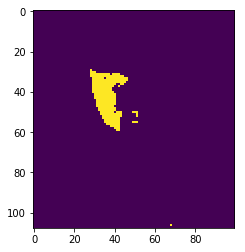

In [10]:
#%%writefile main_segmentation_functions.py
from read_files import read_files, normalization, resize_volume
import os
import scipy.io as spio
from automaticSeeding_method1 import find_seed
#from mayavi import mlab


"""
## visualization - doesn't work because # Child is launched. Close the parent's copy of those pipe; OSError: [WinError 87] O parâmetro está incorreto

import matplotlib.pyplot as plt
import matplotlib.animation as manim

fig2 = plt.figure(figsize=(3,3))
axes  = fig2.add_subplot(111)
img = axes.imshow(imutils.rotate(normalized_array[:,:,305],180), vmin=-1, vmax=1,
                cmap=plt.cm.gray,
                interpolation='bilinear')

writer = manim.ImageMagickWriter(fps=3)
with writer.saving(fig2, 'patient.gif', 100):
       
    for i in range(normalized_array.shape[2]):
        print(i)
        img.set_data(vol[:,:,i])
        axes.set_title("%02d" % i)
        writer.grab_frame()
        
"""


def main():

    folder_path = 'C:/Data/'
    patients_folder= os.listdir(folder_path)#+folder_name)                    
    slices,patients = read_files(patients_folder,folder_path)
    normalized_volume=normalization(slices)
    normalized_array = np.array(normalized_volume)
    pix_resampled, spacing = resample(normalized_array, slices, [5,5,5])
   
    indexes = spio.loadmat('lungs_coordinates - 43181879.mat', squeeze_me=True)["indexes"] 

    mask = np.zeros(normalized_array.shape)
    for s in indexes:
        mask[s[0],s[1],s[2]]=1

    #resized_mask = resize_mask(mask,img_size)
    #reduced_mask = resized_mask[40:127,:,:]

    #    return normalized_array, eroded_volume, resized_array,reduced_array, mask, resized_mask


    #reduced 50/non-reduced 70
    #normalized_array, eroded_volume, resized_array,reduced_array, mask, resized_mask = open_files_default(img_size)

    #GROWING
    seed_reduced=[75,75,50]#[40,50,35]
    seed_reduced_2=[75,75,50]#[50,50,65]

    #Paciente 2
    #seeds = [seed_reduced_2,seed_reduced]

    seed_1 = [40,50,35]
    #seed_1 = find_seed(pix_resampled,50,'left') #tupla
    #seed_2 = find_seed(pix_resampled,50)
    seeds = [seed_1] #lista
    start = time.time()
    #thresh = 300, vizinhanca = 1
    seg = np.zeros(pix_resampled.shape, dtype=np.bool)

    size_seeds = len(seeds)

    if size_seeds>1:
        for i in range(len(seeds)-1):
            seg, counter = grow(pix_resampled,seeds[i],275,1,seg) 
            print('finish:'+str(i))

    else:
        pre_seed = tuple(seeds[0])
        seg, counter = grow(pix_resampled,pre_seed,325,1,seg)
    stop = time.time()
    plt.imshow(seg[:,50,:])
    print("Elapsed time: %.3f seconds." % (stop - start))

    ##OTHER CELL
    #!pip install mayavi
    #fig, ax = plt.subplots()
    #cs = ax.imshow(seg[:,70,:])

    #    np.save("normalized_array",normalized_array)
    #    #np.save("eroded_volume",eroded_volume)
    #    np.save("segmented_volume", seg)
    #    np.save("3DVolumeSegmented_100_300",seg)


#     for i in range(70):
#         fig, ax = plt.subplots()
#         cs = ax.imshow(seg[:,i,:])#36
#         plt.show()
#         print(i)
#         time.sleep(1)
# 
    #plt.imshow(resized_array[:,75,:])
    #testing_seeds(seed_1=[13,75,50], seed_2=[13,75,75], slide=75,volume=resized_array)



if __name__=="__main__":
    main()

In [9]:

folder_path = 'C:/Users/Ana Oliveira/Downloads/Tese/Testes/Dados/'
patients_folder= os.listdir(folder_path)#+folder_name)                    
slices,patients = read_files(patients_folder,folder_path)
normalized_volume=normalization(slices)
normalized_array = np.array(normalized_volume)
pix_resampled, spacing = resample(normalized_array, slices, [5,5,5])
indexes = spio.loadmat('lungs_coordinates - 43181879.mat', squeeze_me=True)["indexes"] 

mask = np.zeros(normalized_array.shape)
for s in indexes:
    mask[s[0],s[1],s[2]]=1
seed_1 = [40,50,35]
seeds = [seed_1] #lista
seg = np.zeros(pix_resampled.shape, dtype=np.bool)
pre_seed = tuple(seeds[0])
seg[pre_seed]
#seg, counter = grow(pix_resampled,pre_seed[0],325,1,seg)

False

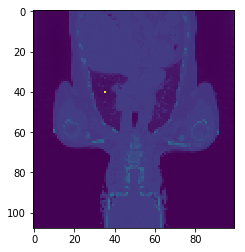

In [14]:
pix_resampled[40,50,35]=5000
plt.imshow(pix_resampled[:,50,:])

In [13]:
pre_seed

(40, 50, 35)

In [24]:
seg = np.zeros(pix_resampled.shape, dtype=np.bool)
np.amin(seg)

False